<Figure size 1000x600 with 0 Axes>

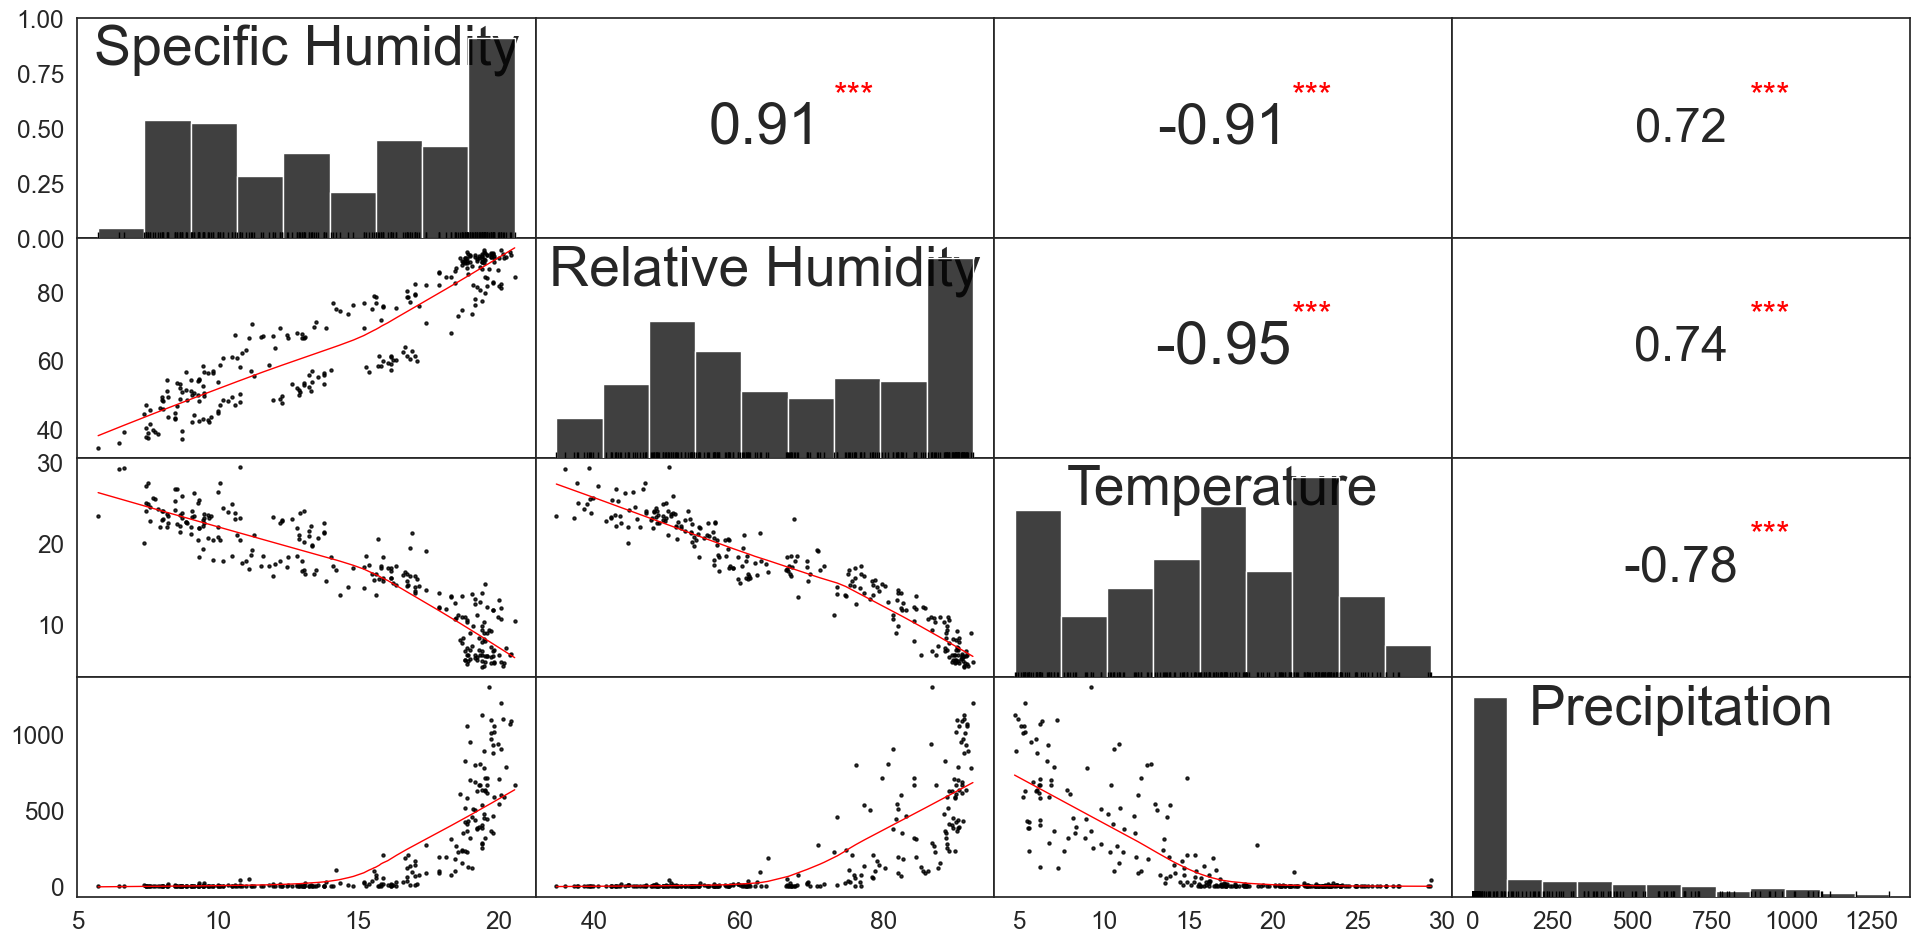

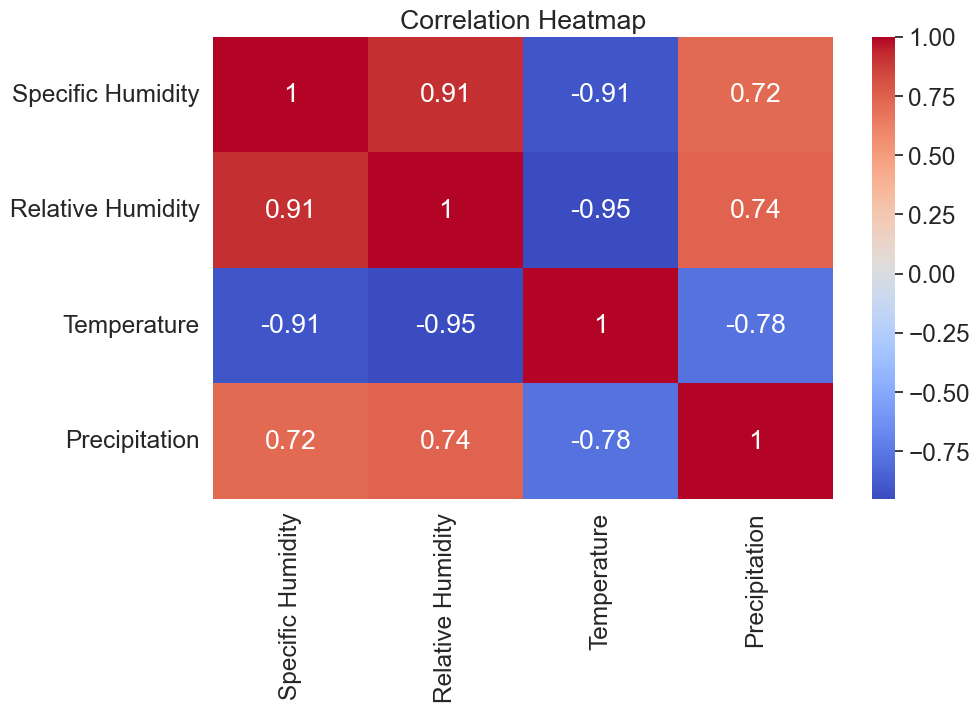

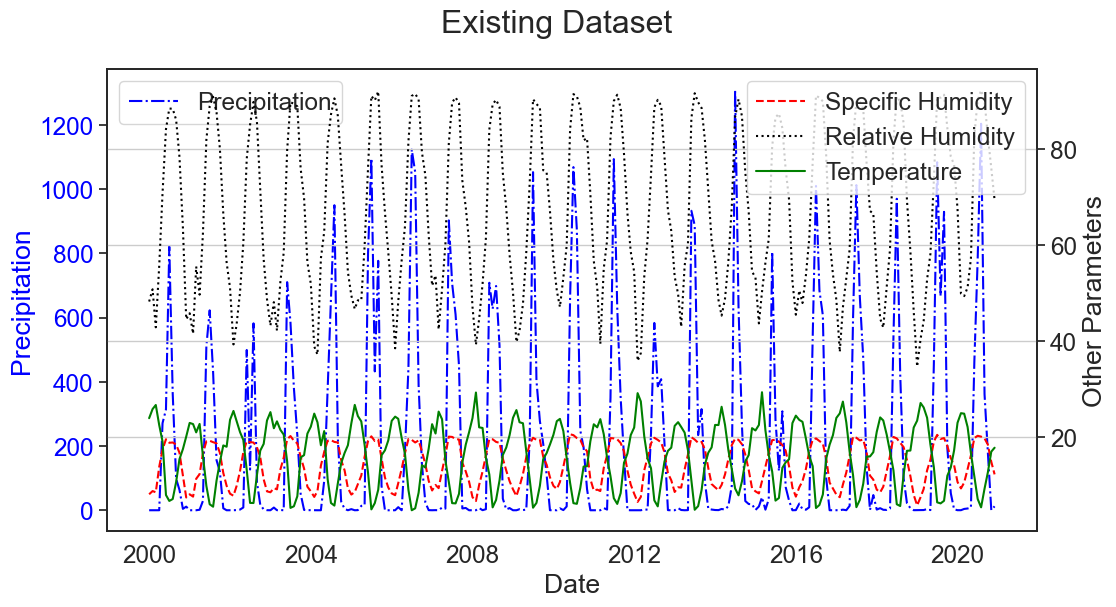

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from scipy import stats
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import save_model
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import joblib
from datetime import timedelta
from sklearn.metrics import r2_score


def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Create output folders
base_dir = "Output_03"
plots_dir = os.path.join(base_dir, "plots")
models_dir = os.path.join(base_dir, "models")
results_dir = os.path.join(base_dir, "results")
input_dir = os.path.join(base_dir, "input")
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)

# Load data
data = pd.read_csv("Weather_Data.csv")
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('Date', inplace=True)
data = data[['Specific Humidity', 'Relative Humidity', 'Temperature', 'Precipitation']]

# Fill missing values with column means
data.fillna(data.mean(), inplace=True)


# Define features and target
features = data.columns

font_size = 26

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = round(corr_r, 2)
    ax = plt.gca()
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=25)


fm_input_comb = data
plt.figure(figsize=(10, 6))
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(fm_input_comb, aspect=2, diag_sharey=False, despine=False)
g.map_lower(sns.regplot, lowess=True, ci=False,
            line_kws={'color': 'red', 'lw': 1},
            scatter_kws={'color': 'black', 's': 5})
g.map_diag(sns.histplot, color='black',
           kde_kws={'color': 'red', 'cut': 0.5, 'lw': 1},
                     )
g.map_diag(sns.rugplot, color='black')
g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), fm_input_comb.columns):
    ax.set_title(col, y=0.75, fontsize=40)

plt.savefig('./Output_03/plots/WQI_corr_1.png', dpi = 300)
plt.savefig(os.path.join(base_dir, "plots", "WQI_corr_1.png"), dpi = 300)
plt.show()
plt.show()
plt.close()
font_scale=1

plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("./Output_03/plots/correlation_heatmap.png")
plt.show()
plt.close()

# Define line styles and colors for each feature
line_styles = {
    'Precipitation': '-.',
    'Specific Humidity': '--',
    'Relative Humidity': ':',
    'Temperature': '-'
}
line_colors = {
    'Precipitation': 'blue',
    'Specific Humidity': 'red',
    'Relative Humidity': 'black',
    'Temperature': 'green'
}

# Function to plot the existing dataset with dual axes
def plot_existing_data(data):
    """Plot the existing dataset with separate axes for Precipitation and other parameters."""
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot precipitation on the first y-axis
    color = line_colors['Precipitation']
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Precipitation', color=color)
    ax1.plot(data.index, data['Precipitation'], label='Precipitation', color=color, linestyle=line_styles['Precipitation'])
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for other weather parameters
    ax2 = ax1.twinx()
    ax2.set_ylabel('Other Parameters')

    # Plot each feature with a unique line style and color
    for feature in features:
        if feature != 'Precipitation':
            ax2.plot(
                data.index, 
                data[feature], 
                label=feature, 
                linestyle=line_styles.get(feature, '-'),
                color=line_colors.get(feature, 'black')
            )
    
    # Add title and legends
    fig.suptitle("Existing Dataset")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.grid()
    plt.savefig("./Output_03/plots/existing_data.png")
    plt.show()

# Plot the existing data
plot_existing_data(data)


In [15]:
# Scale data
scalers = {}
scaled_data = {}
for col in data.columns:
    scaler = MinMaxScaler()
    scaled_data[col] = scaler.fit_transform(data[[col]])
    scalers[col] = scaler

data_scaled = pd.DataFrame({col: scaled_data[col].flatten() for col in data.columns}, index=data.index)
X = data_scaled.drop(columns=['Precipitation']).values
y = data_scaled['Precipitation'].values

# Initialize models
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()
svm_model = SVR()

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Optimize hyperparameters
def optimize_hyperparameters(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
gb_param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
svm_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]}

# TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare storage for results
y_train_splits, y_test_splits = [], []
rf_pred_train_splits, rf_pred_test_splits = [], []
gb_pred_train_splits, gb_pred_test_splits = [], []
svm_pred_train_splits, svm_pred_test_splits = [], []
lstm_pred_train_splits, lstm_pred_test_splits = [], []
train_index_splits, test_index_splits = [], []

# Train and predict for each split
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_index_splits.append(data.index[train_idx])
    test_index_splits.append(data.index[test_idx])
    y_train_splits.append(y_train)
    y_test_splits.append(y_test)

    # Optimize and train models
    rf_model_optimized = optimize_hyperparameters(RandomForestRegressor(), rf_param_grid, X_train, y_train)
    rf_pred_train_splits.append(rf_model_optimized.predict(X_train))
    rf_pred_test_splits.append(rf_model_optimized.predict(X_test))

    gb_model_optimized = optimize_hyperparameters(GradientBoostingRegressor(), gb_param_grid, X_train, y_train)
    gb_pred_train_splits.append(gb_model_optimized.predict(X_train))
    gb_pred_test_splits.append(gb_model_optimized.predict(X_test))

    svm_model_optimized = optimize_hyperparameters(SVR(), svm_param_grid, X_train, y_train)
    svm_pred_train_splits.append(svm_model_optimized.predict(X_train))
    svm_pred_test_splits.append(svm_model_optimized.predict(X_test))

    # LSTM
    lstm_model = create_lstm_model((X_train.shape[1], 1))
    lstm_model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=10, batch_size=32, verbose=0)
    lstm_pred_train_splits.append(lstm_model.predict(X_train.reshape(-1, X_train.shape[1], 1)).flatten())
    lstm_pred_test_splits.append(lstm_model.predict(X_test.reshape(-1, X_test.shape[1], 1)).flatten())

# Metrics
results = {}
models = {
    "Random Forest": (rf_pred_train_splits, rf_pred_test_splits),
    "Gradient Boosting": (gb_pred_train_splits, gb_pred_test_splits),
    "SVM": (svm_pred_train_splits, svm_pred_test_splits),
    "LSTM": (lstm_pred_train_splits, lstm_pred_test_splits),
}

for model_name, (train_preds, test_preds) in models.items():
    results[model_name] = {
        "train_rmse": [mean_squared_error(y_train, train_pred, squared=False) for y_train, train_pred in zip(y_train_splits, train_preds)],
        "test_rmse": [mean_squared_error(y_test, test_pred, squared=False) for y_test, test_pred in zip(y_test_splits, test_preds)],
        "train_r2": [r2_score(y_train, train_pred) for y_train, train_pred in zip(y_train_splits, train_preds)],
        "test_r2": [r2_score(y_test, test_pred) for y_test, test_pred in zip(y_test_splits, test_preds)],
    }

# Function to create combined plots for a model
def plot_combined_metrics(y_train, y_train_pred, y_test, y_test_pred, model_name, index_train, index_test, save_dir):
    # Calculate metrics
    train_mse, train_mae, train_r2 = calculate_metrics(y_train, y_train_pred)
    test_mse, test_mae, test_r2 = calculate_metrics(y_test, y_test_pred)

    # Create the figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot 1: Time series (Actual vs Predicted)
    axes[0, 0].plot(index_train, scalers['Precipitation'].inverse_transform(y_train.reshape(-1, 1)), label="Training Actual", color='blue', linestyle='-')
    axes[0, 0].plot(index_train, scalers['Precipitation'].inverse_transform(y_train_pred.reshape(-1, 1)), label="Training Predicted", color='red', linestyle='-.')
    axes[0, 0].plot(index_test, scalers['Precipitation'].inverse_transform(y_test.reshape(-1, 1)), label="Test Actual", color='green', linestyle='-')
    axes[0, 0].plot(index_test, scalers['Precipitation'].inverse_transform(y_test_pred.reshape(-1, 1)), label="Test Predicted", color='black', linestyle='-.')
    axes[0, 0].set_title("Actual vs Predicted (Time Series)")
    axes[0, 0].legend()
    axes[0, 0].set_xlabel("Date")
    axes[0, 0].set_ylabel("Precipitation (mm)")
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Scatter plot (Actual vs Predicted)
    axes[0, 1].scatter(scalers['Precipitation'].inverse_transform(y_test.reshape(-1, 1)), 
                        scalers['Precipitation'].inverse_transform(y_test_pred.reshape(-1, 1)), 
                        color='purple', alpha=0.6, edgecolor='k')
    axes[0, 1].plot([0, 1], [0, 1], transform=axes[0, 1].transAxes, color='red', linestyle='--', label="1:1 Line")
    axes[0, 1].set_title("Scatter Plot (Test Set)")
    axes[0, 1].set_xlabel("Actual Precipitation (mm)")
    axes[0, 1].set_ylabel("Predicted Precipitation (mm)")
    axes[0, 1].legend()

    # Plot 3: Metrics table
    metrics_table = f"""Training Metrics:
    MSE: {train_mse:.2f}
    MAE: {train_mae:.2f}
    R2: {train_r2:.2f}

    Testing Metrics:
    MSE: {test_mse:.2f}
    MAE: {test_mae:.2f}
    R2: {test_r2:.2f}"""
    axes[1, 0].axis("off")
    axes[1, 0].text(0.1, 0.5, metrics_table, fontsize=12, va="center", ha="left")
    axes[1, 0].set_title("Metrics Summary")

    # Plot 4: Placeholder for model description (Optional)
    axes[1, 1].axis("off")
    axes[1, 1].text(0.5, 0.5, f"{model_name}", fontsize=16, va="center", ha="center")

    # Adjust layout
    plt.tight_layout()

    # Save plot
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, f"{model_name}_Combined_Plot.png"))
    plt.show()


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
2/2 ━━━━━━━━

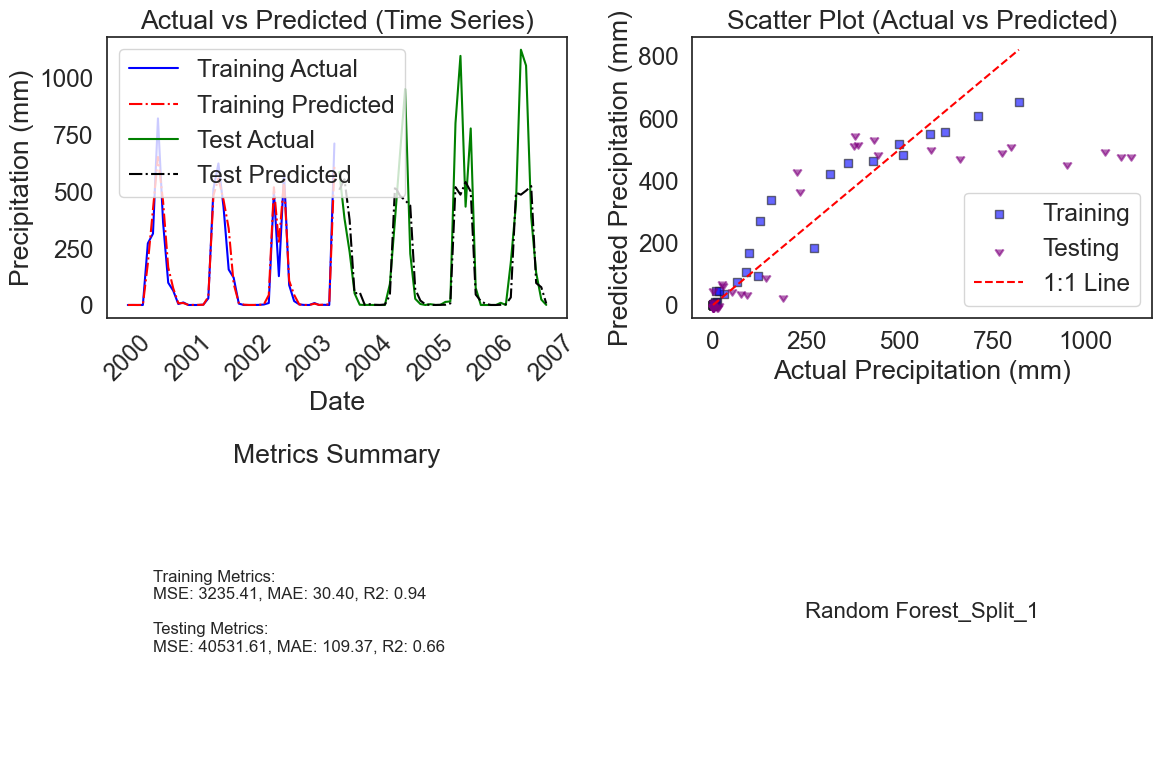

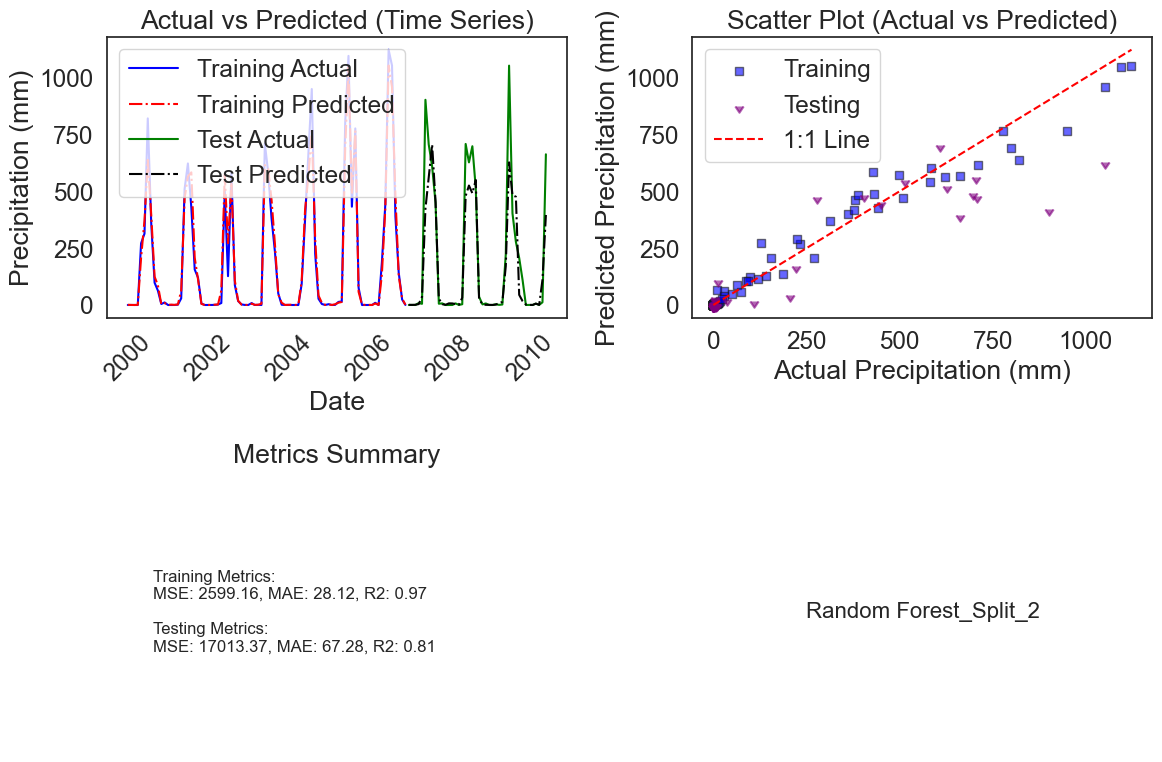

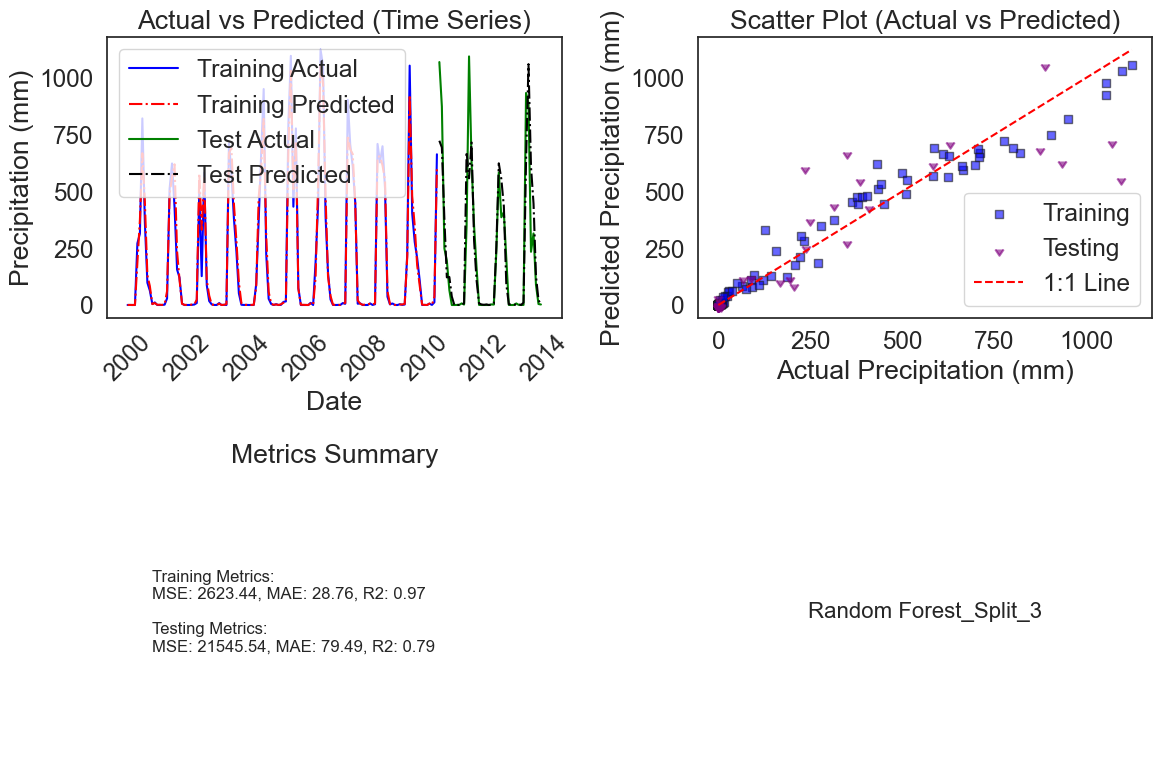

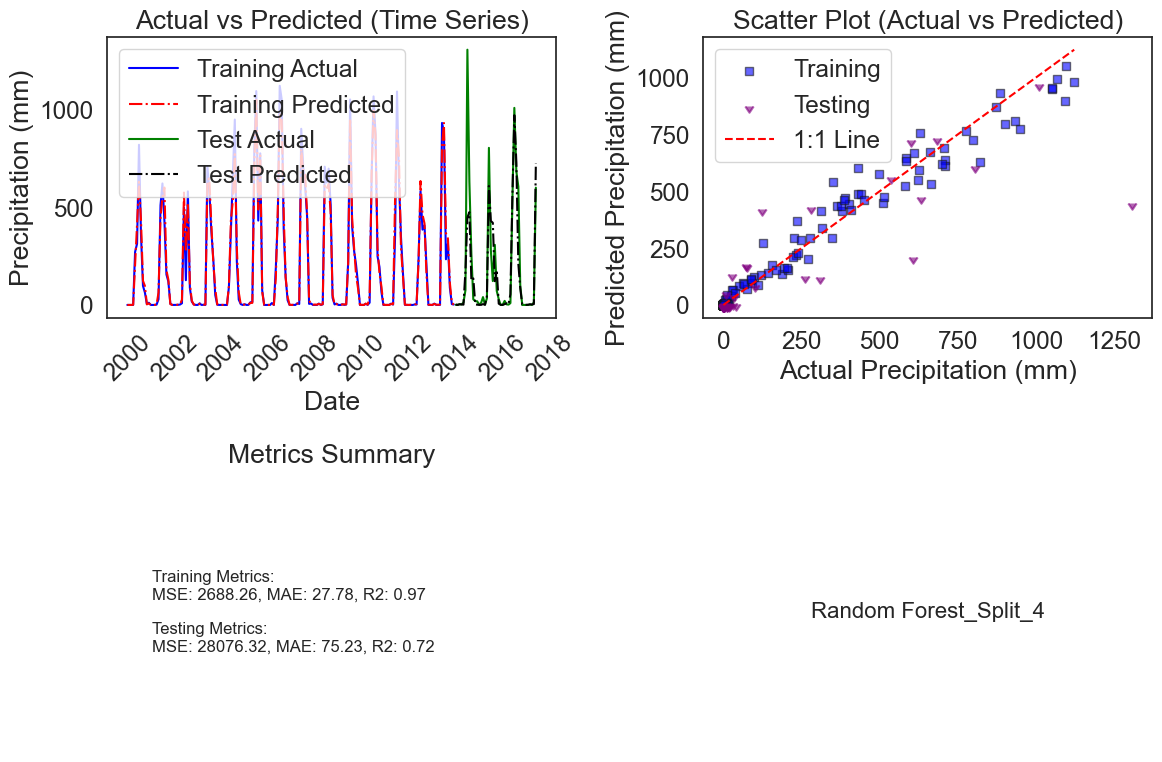

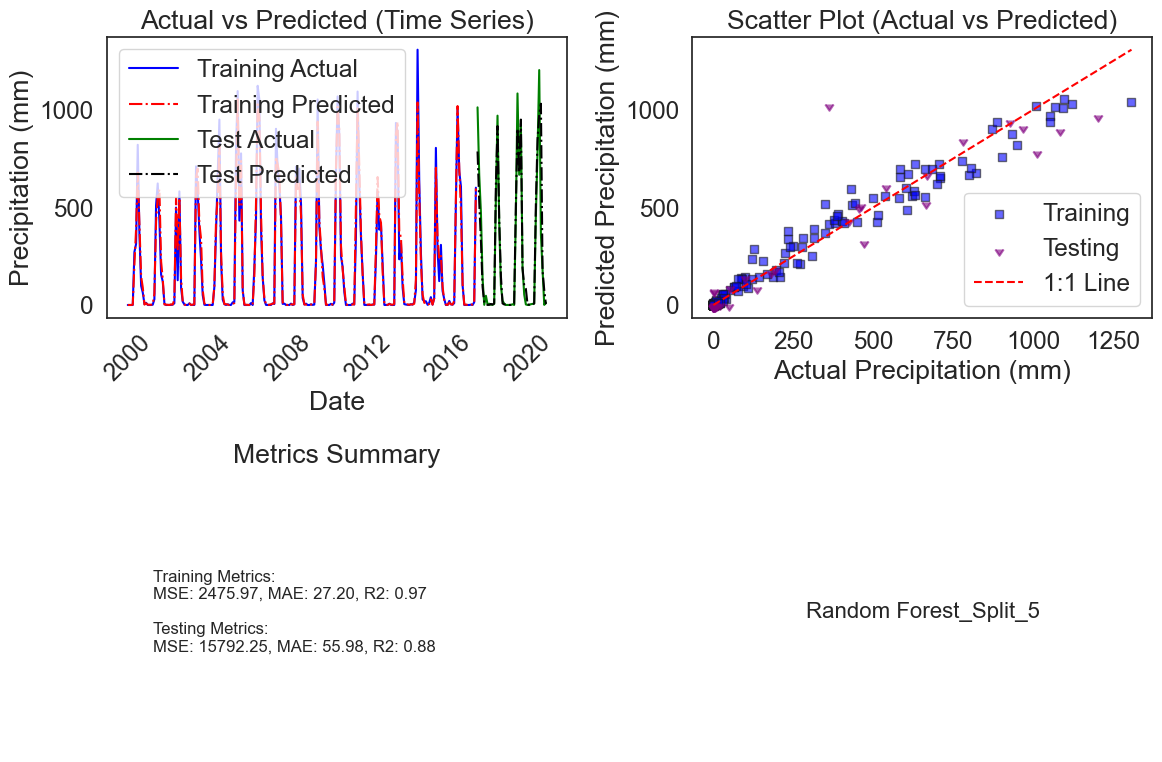

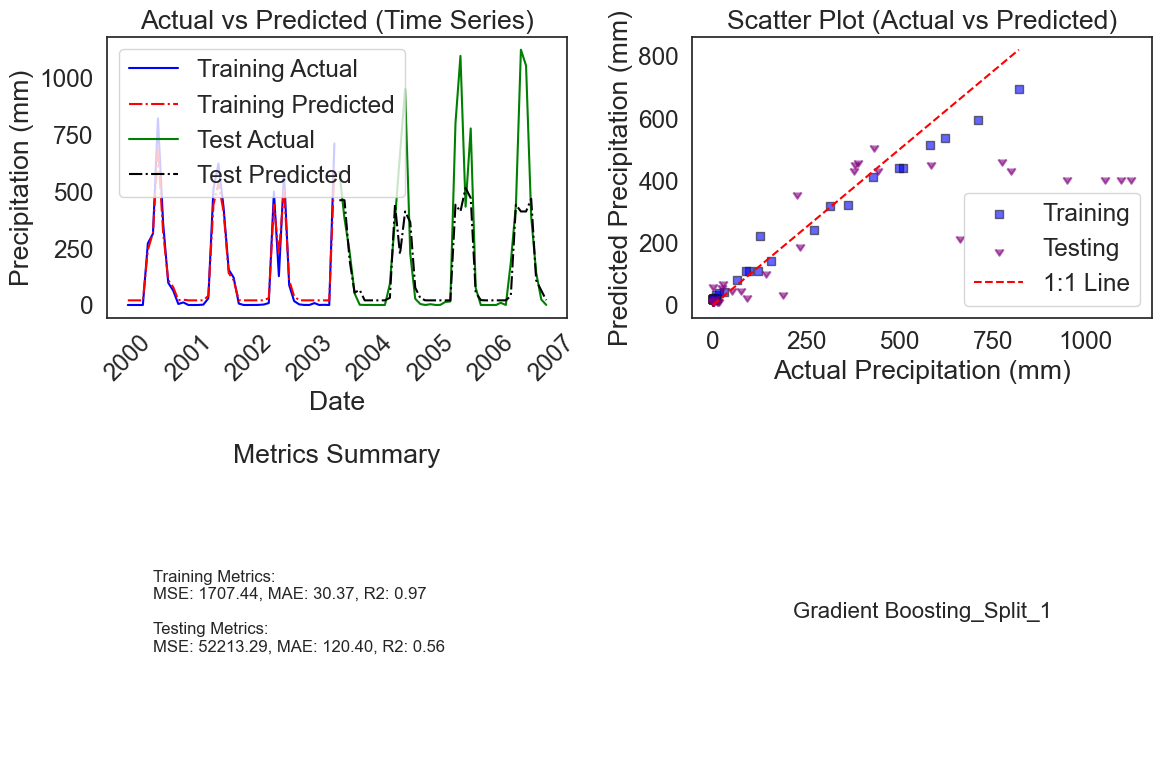

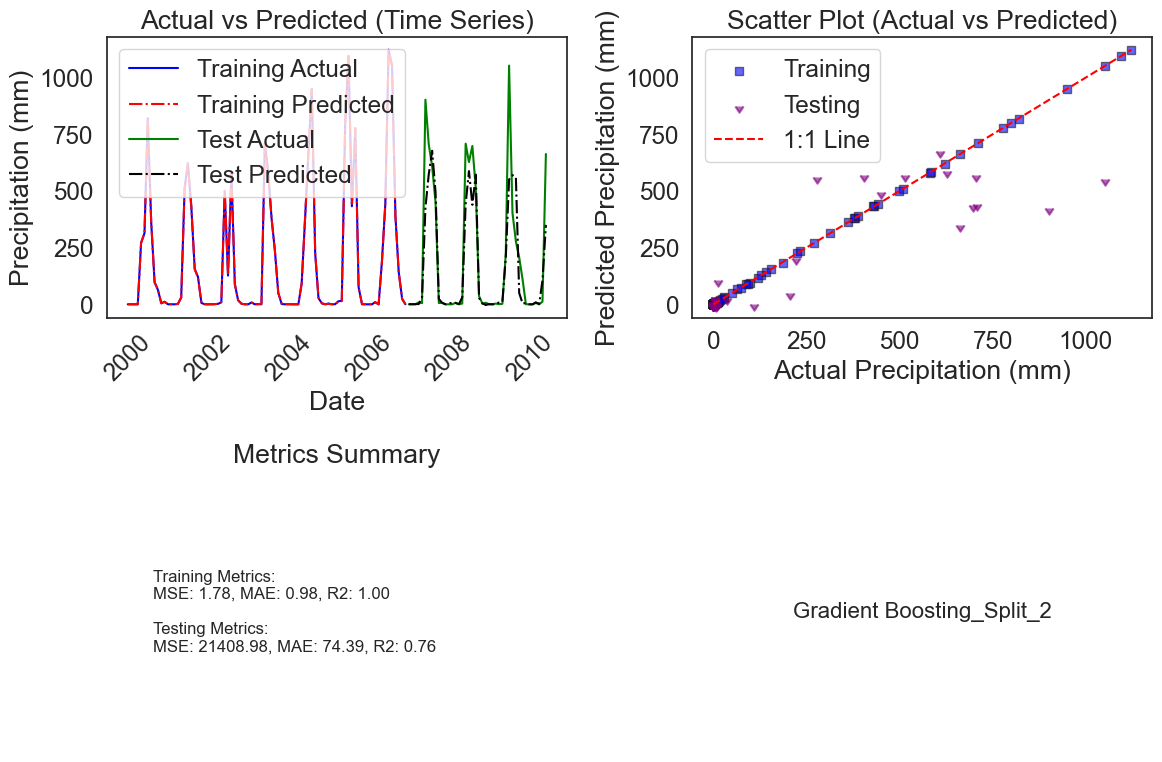

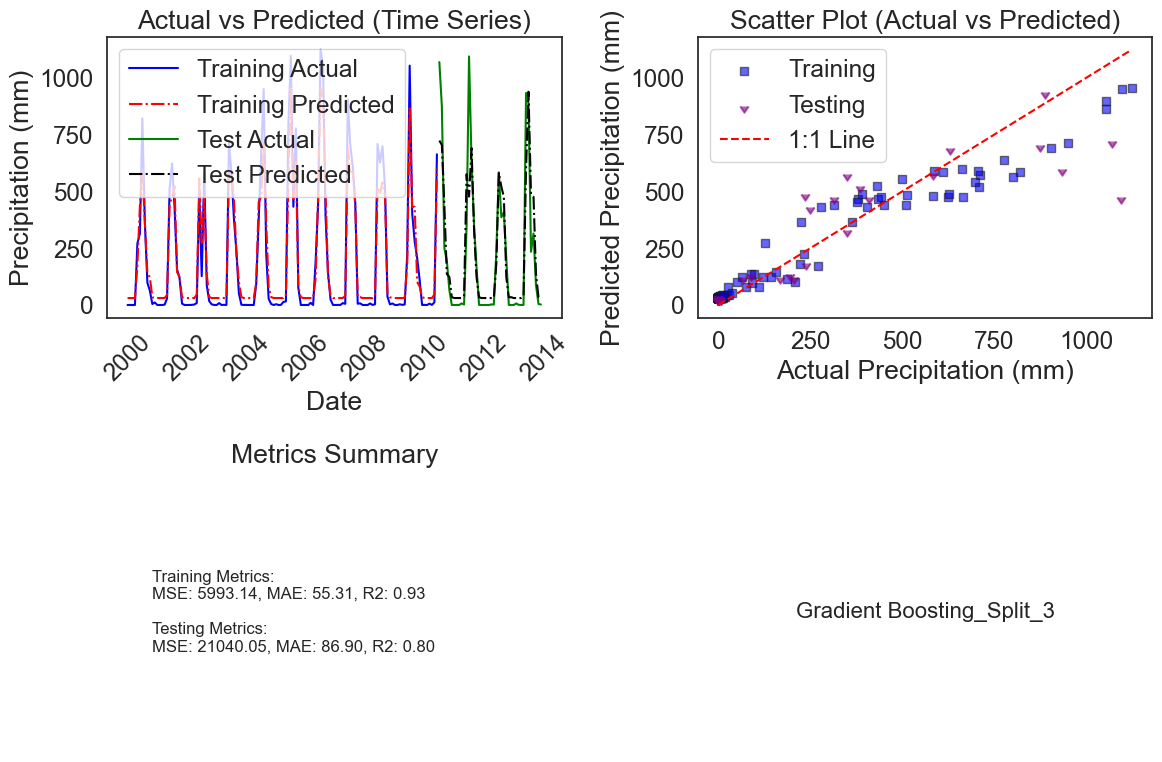

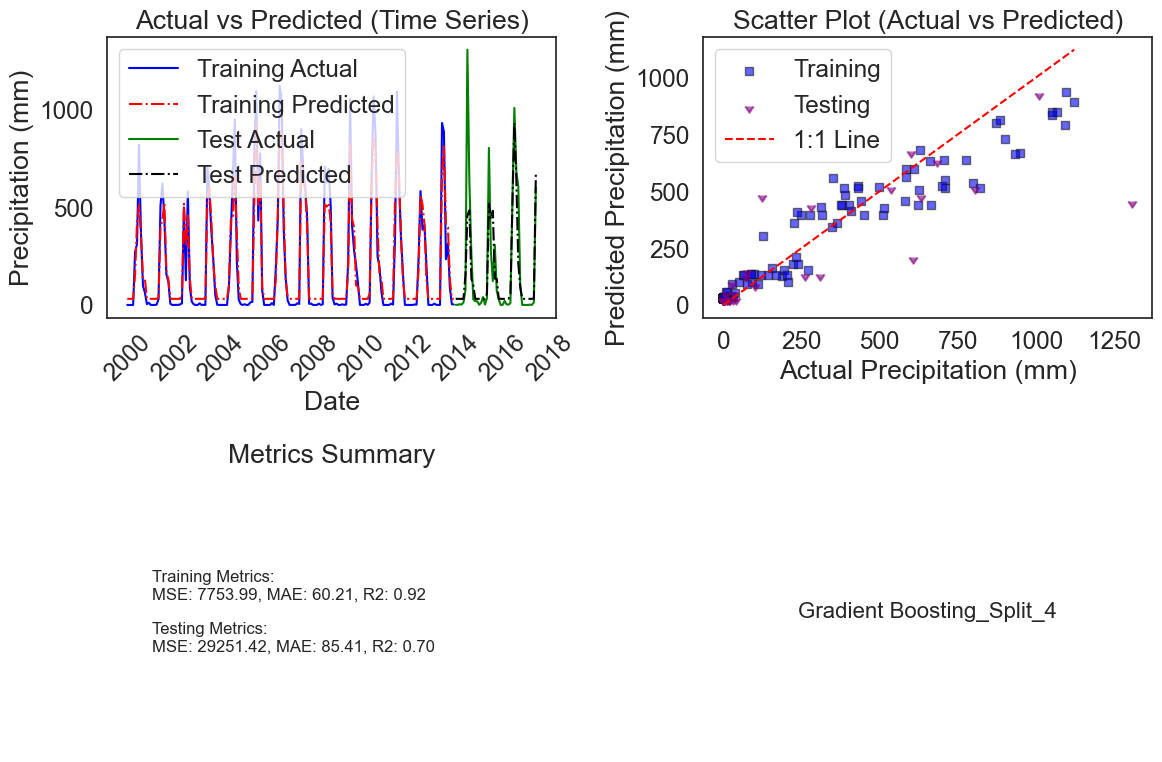

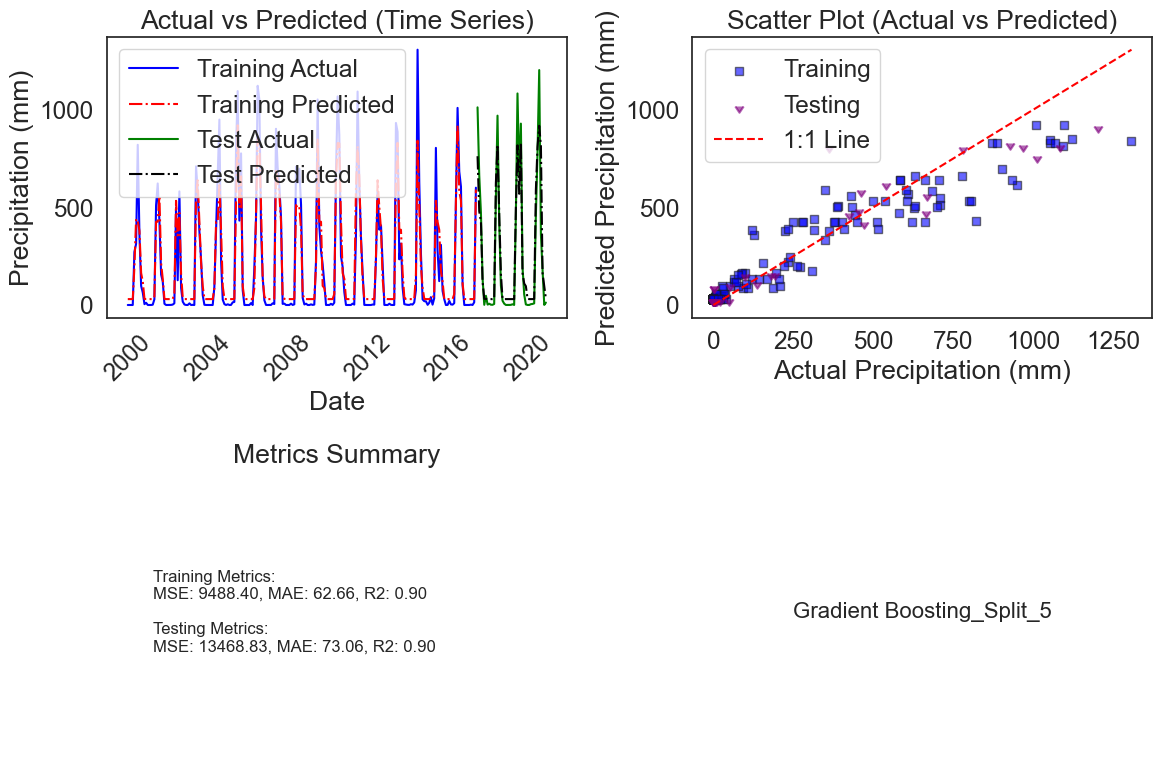

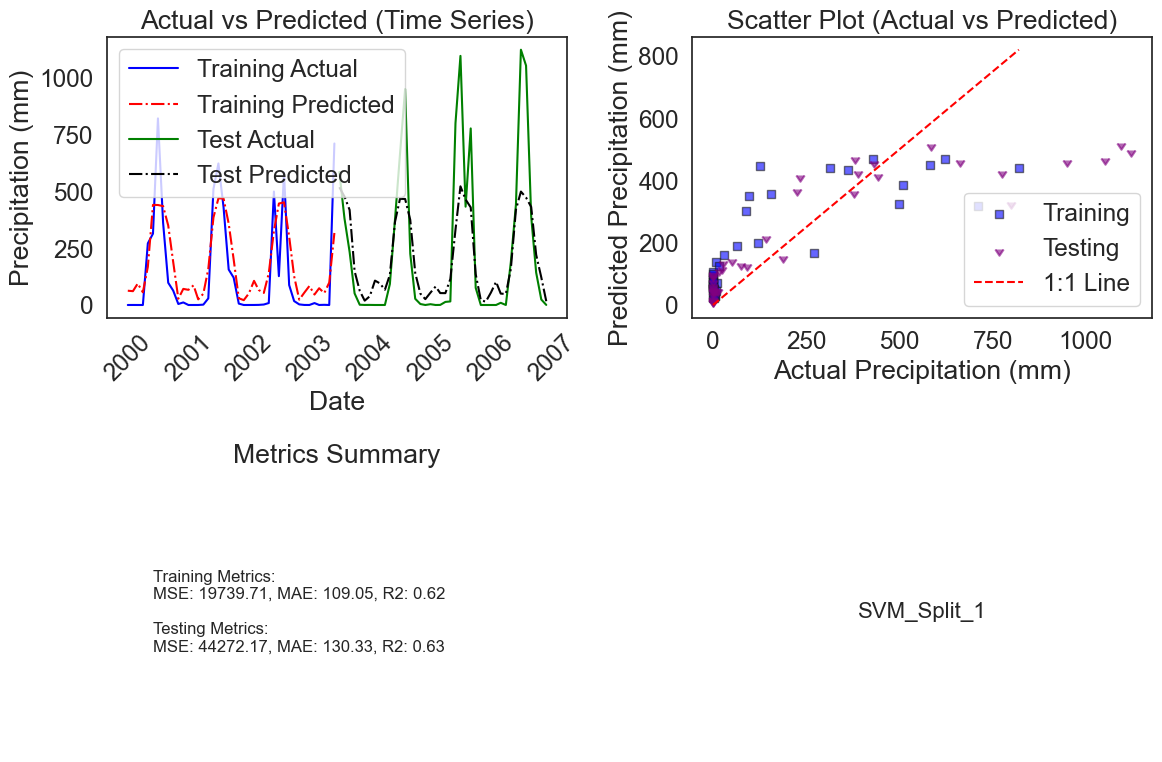

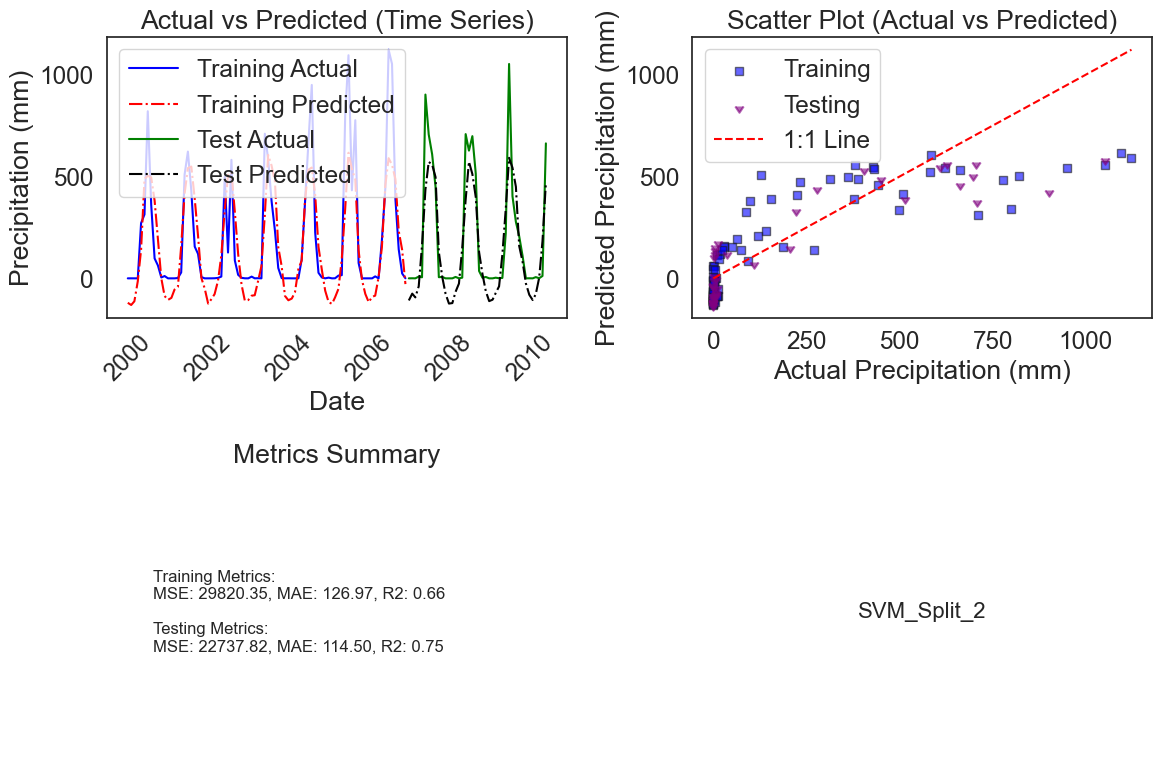

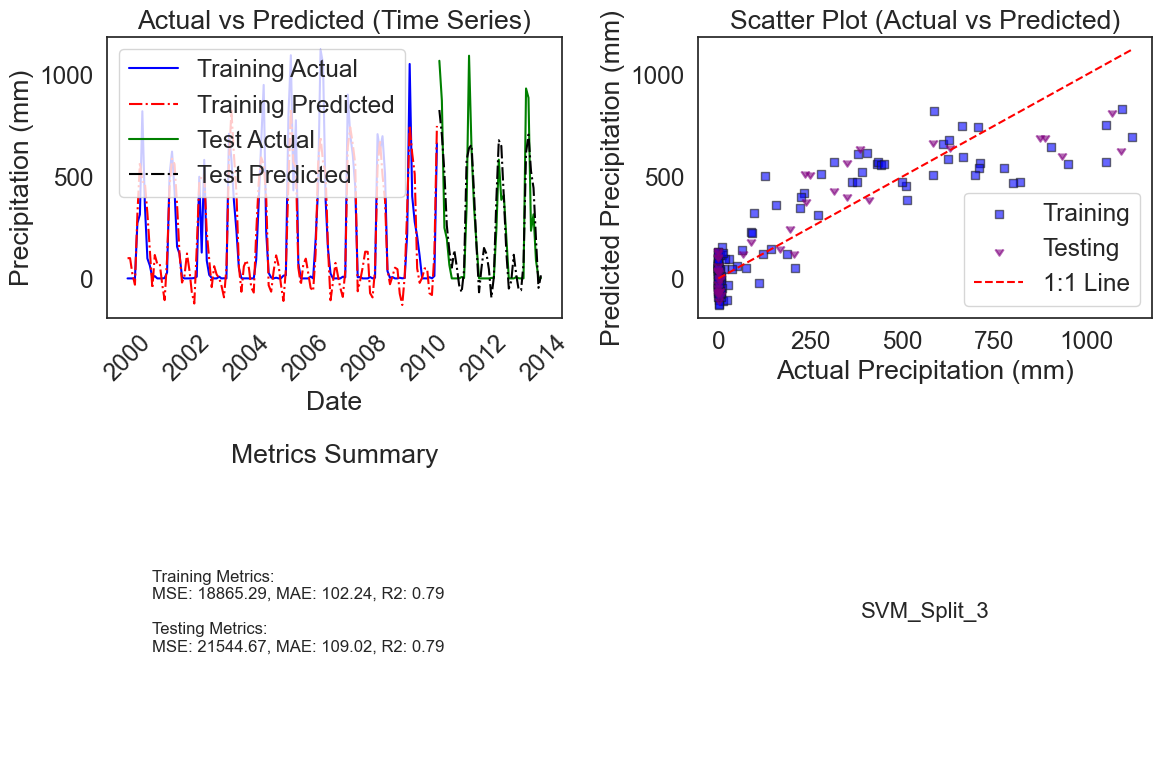

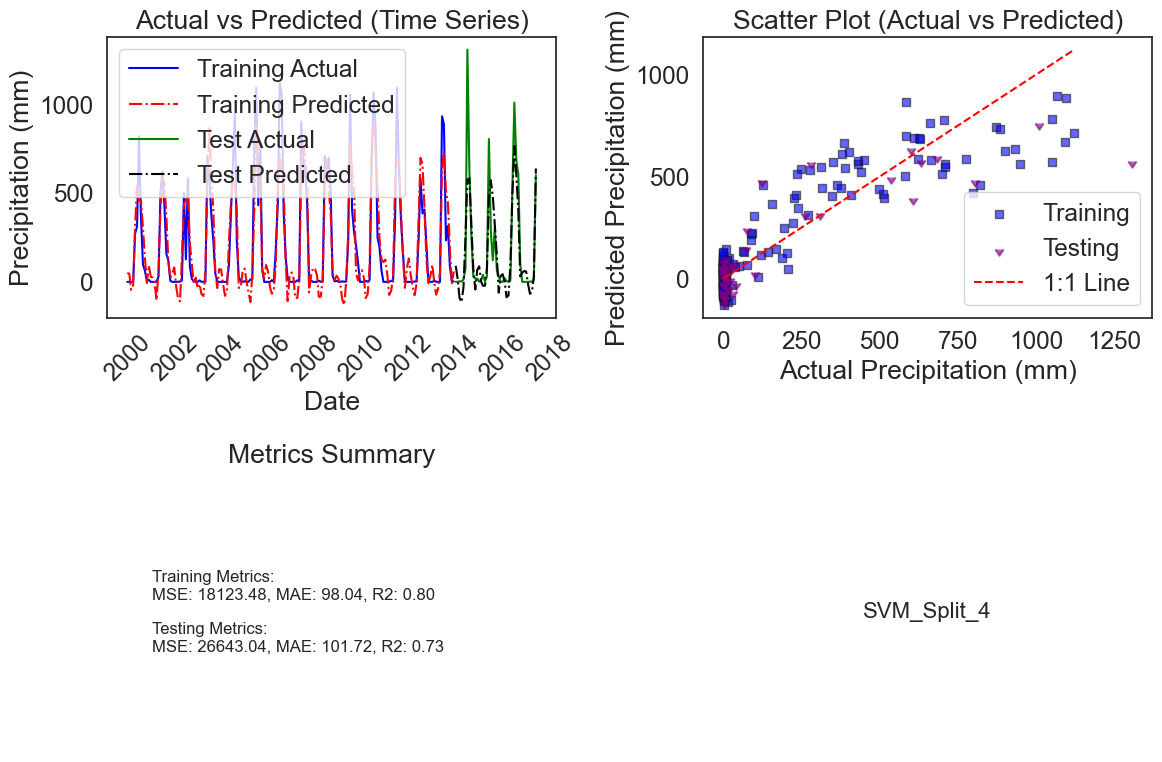

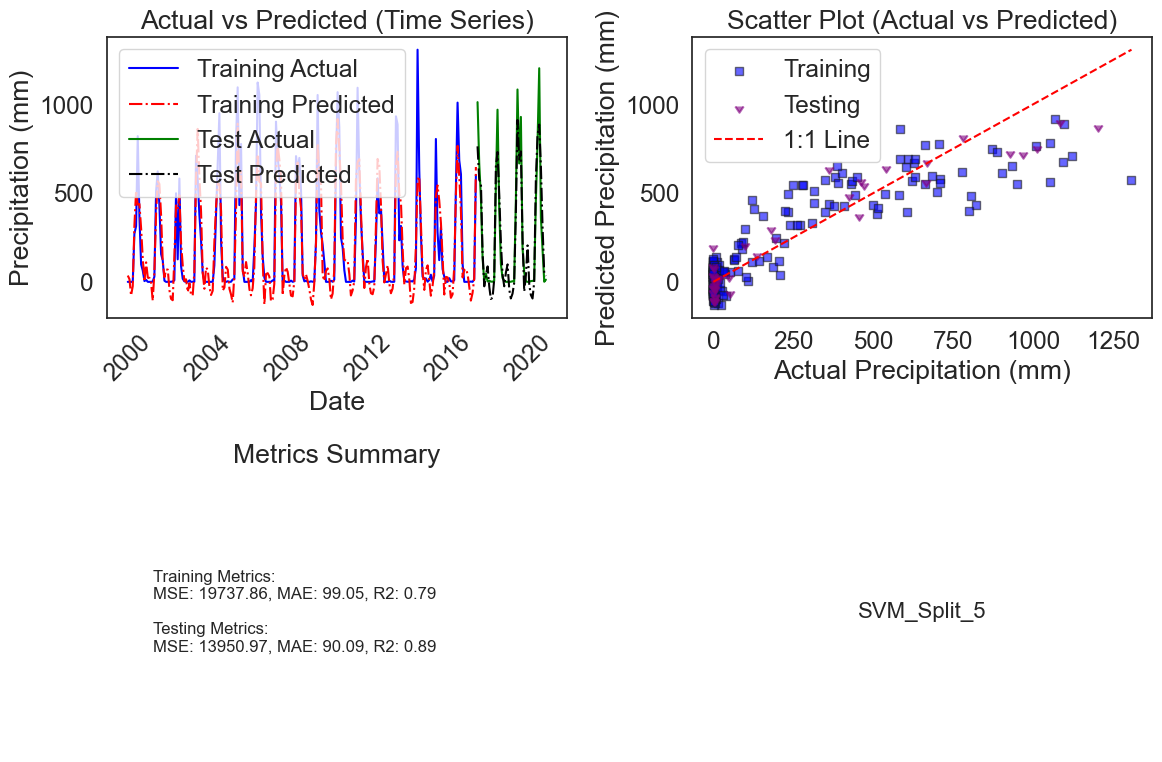

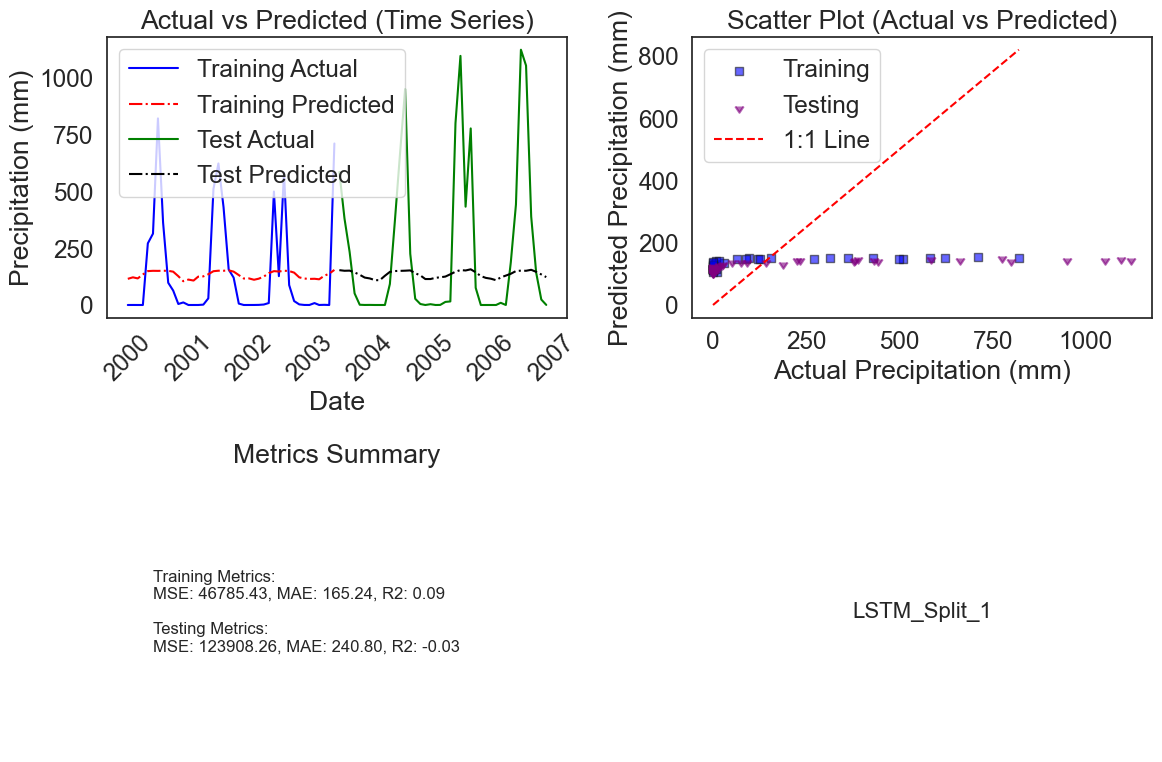

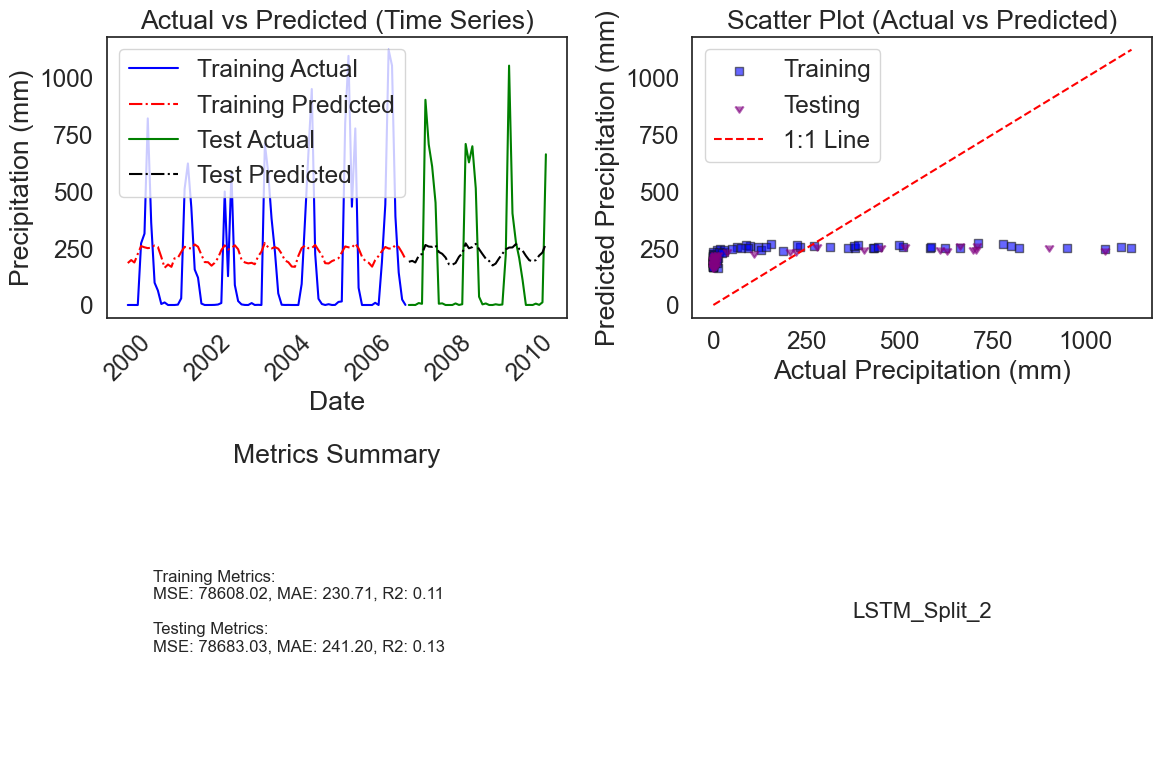

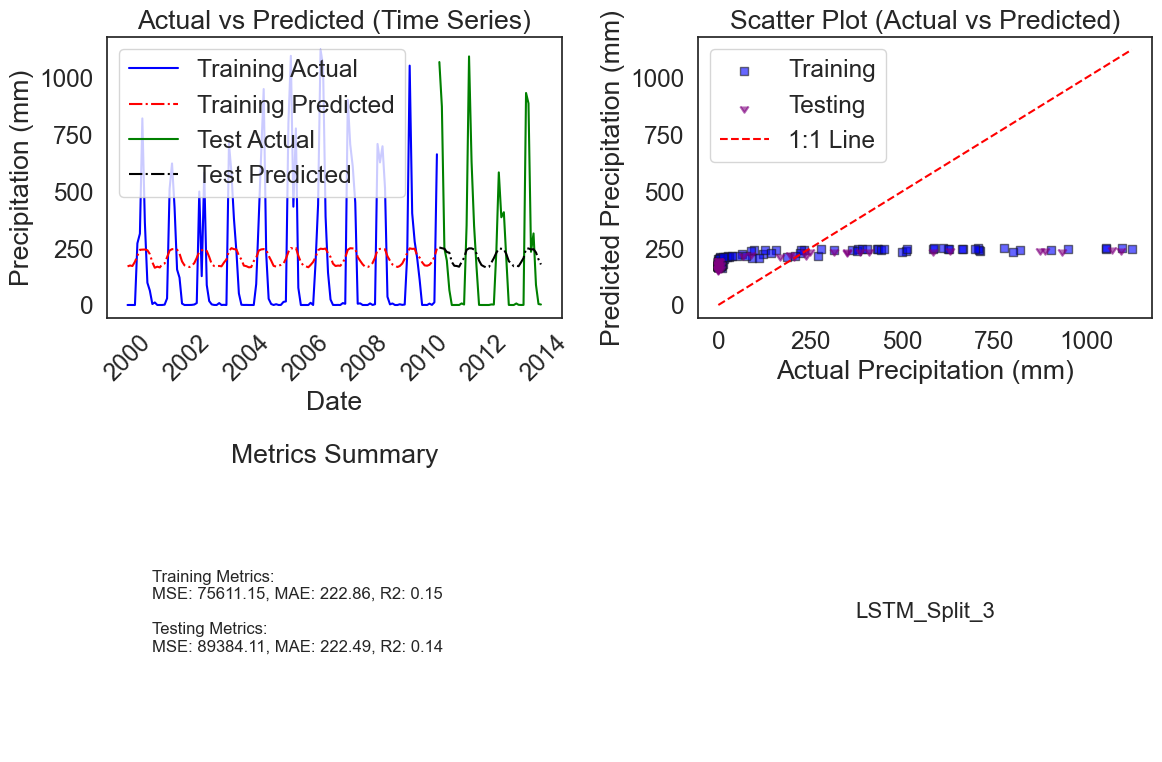

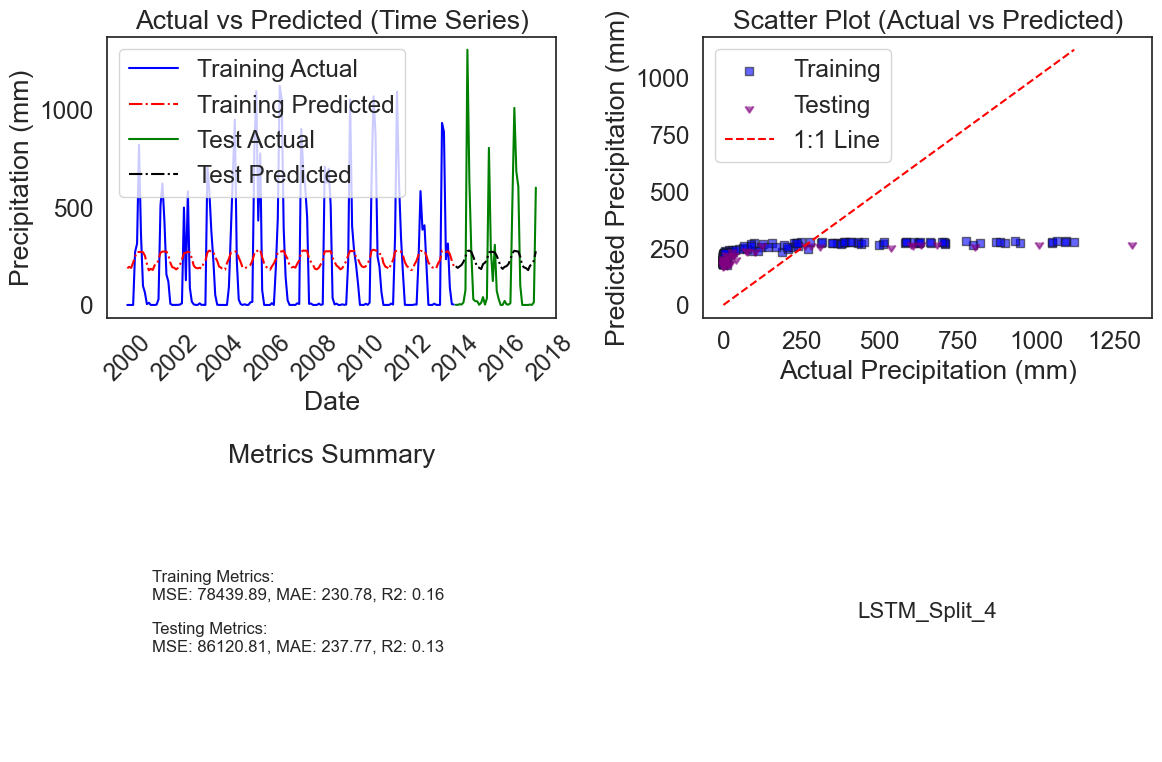

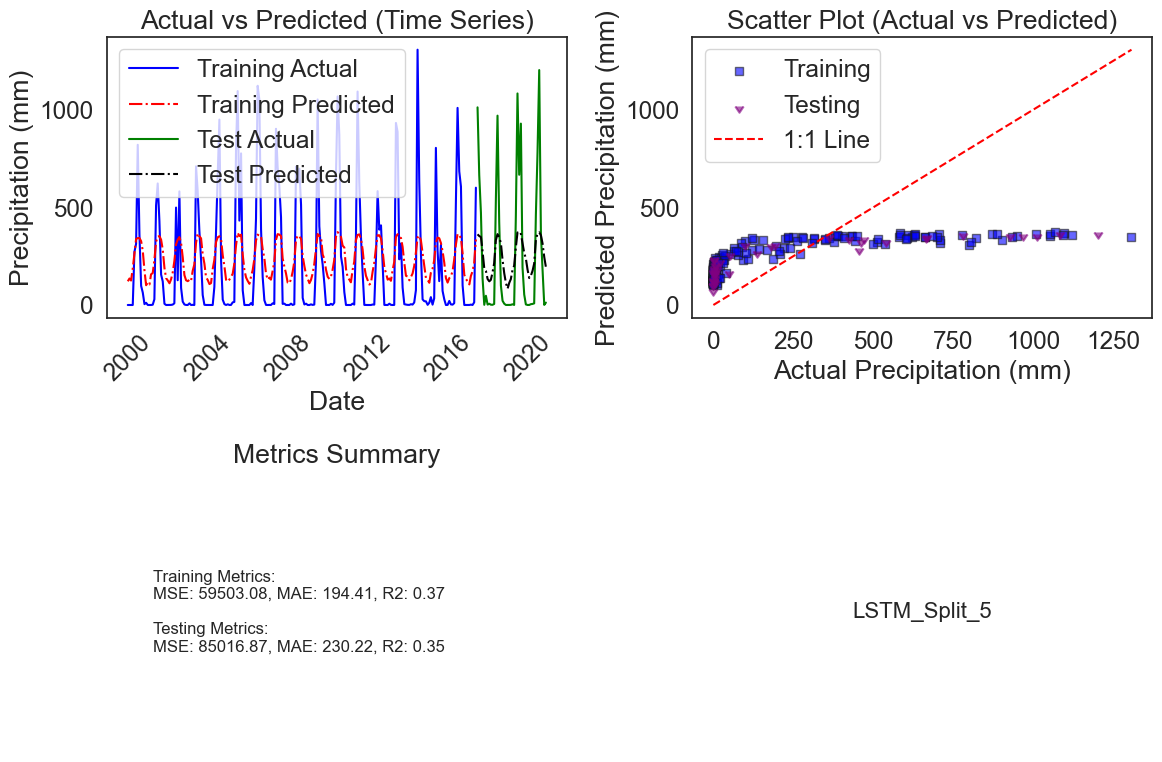

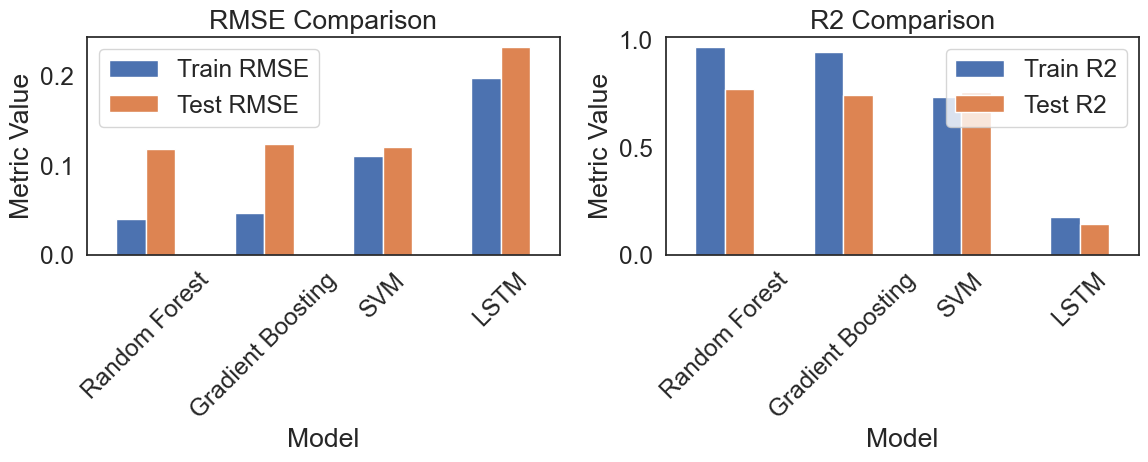

The best model is Random Forest, and it has been saved.


In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import joblib
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Function to create combined plots for a model
def plot_combined_metrics(y_train, y_train_pred, y_test, y_test_pred, model_name, index_train, index_test, save_dir):
    # Calculate metrics
    train_mse, train_mae, train_r2 = calculate_metrics(y_train, y_train_pred)
    test_mse, test_mae, test_r2 = calculate_metrics(y_test, y_test_pred)

    # Create the figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot 1: Time series (Actual vs Predicted)
    axes[0, 0].plot(index_train, y_train, label="Training Actual", color='blue', linestyle='-')
    axes[0, 0].plot(index_train, y_train_pred, label="Training Predicted", color='red', linestyle='-.')
    axes[0, 0].plot(index_test, y_test, label="Test Actual", color='green', linestyle='-')
    axes[0, 0].plot(index_test, y_test_pred, label="Test Predicted", color='black', linestyle='-.')
    axes[0, 0].set_title("Actual vs Predicted (Time Series)")
    axes[0, 0].legend()
    axes[0, 0].set_xlabel("Date")
    axes[0, 0].set_ylabel("Precipitation (mm)")
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Scatter plot (Actual vs Predicted)
    axes[0, 1].scatter(y_train, y_train_pred, color='blue', alpha=0.6, edgecolor='k', label="Training", marker='s')
    axes[0, 1].scatter(y_test, y_test_pred, color='purple', alpha=0.6, edgecolor='k', label="Testing", marker=11)
    axes[0, 1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label="1:1 Line")
    axes[0, 1].set_title("Scatter Plot (Actual vs Predicted)")
    axes[0, 1].set_xlabel("Actual Precipitation (mm)")
    axes[0, 1].set_ylabel("Predicted Precipitation (mm)")
    axes[0, 1].legend()

    # Annotate metrics
    metrics_text = f"Training Metrics:\nMSE: {train_mse:.2f}, MAE: {train_mae:.2f}, R2: {train_r2:.2f}\n\nTesting Metrics:\nMSE: {test_mse:.2f}, MAE: {test_mae:.2f}, R2: {test_r2:.2f}"
    axes[1, 0].axis("off")
    axes[1, 0].text(0.1, 0.5, metrics_text, fontsize=12, va="center", ha="left")
    axes[1, 0].set_title("Metrics Summary")

    # Placeholder for additional information
    axes[1, 1].axis("off")
    axes[1, 1].text(0.5, 0.5, f"{model_name}", fontsize=16, va="center", ha="center")

    # Adjust layout
    plt.tight_layout()

    # Save plot
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(os.path.join(save_dir, f"{model_name}_Combined_Plot.png"))
    plt.show()

# Generate and save plots for each model
for model_name, (train_preds, test_preds) in models.items():
    for split_idx, (y_train, train_pred, y_test, test_pred) in enumerate(zip(y_train_splits, train_preds, y_test_splits, test_preds)):
        plot_combined_metrics(
            y_train=scalers['Precipitation'].inverse_transform(y_train.reshape(-1, 1)),
            y_train_pred=scalers['Precipitation'].inverse_transform(train_pred.reshape(-1, 1)),
            y_test=scalers['Precipitation'].inverse_transform(y_test.reshape(-1, 1)),
            y_test_pred=scalers['Precipitation'].inverse_transform(test_pred.reshape(-1, 1)),
            model_name=f"{model_name}_Split_{split_idx + 1}",
            index_train=train_index_splits[split_idx],
            index_test=test_index_splits[split_idx],
            save_dir=plots_dir
        )

# Comparison plot for all models
comparison_metrics = {
    model_name: {
        'Train RMSE': np.mean(results[model_name]['train_rmse']),
        'Test RMSE': np.mean(results[model_name]['test_rmse']),
        'Train R2': np.mean(results[model_name]['train_r2']),
        'Test R2': np.mean(results[model_name]['test_r2'])
    }
    for model_name in models.keys()
}

comparison_fm_input = pd.DataFrame.from_dict(comparison_metrics, orient='index')
comparison_fm_input.to_csv(os.path.join(base_dir, "comparison_metrics.csv"))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
comparison_fm_input[['Train RMSE', 'Test RMSE']].plot(kind='bar', ax=axes[0], title="RMSE Comparison")
comparison_fm_input[['Train R2', 'Test R2']].plot(kind='bar', ax=axes[1], title="R2 Comparison")
for ax in axes:
    ax.set_xlabel("Model")
    ax.set_ylabel("Metric Value")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "Model_Comparison.png"))
plt.show()

# Save the best model
best_model_name = comparison_fm_input['Test R2'].idxmax()
best_model = {
    "Random Forest": rf_model_optimized,
    "Gradient Boosting": gb_model_optimized,
    "SVM": svm_model_optimized,
    "LSTM": lstm_model
}[best_model_name]

# Save best model
if best_model_name == "LSTM":
    best_model.save(os.path.join(models_dir, "best_model.keras"))
else:
    joblib.dump(best_model, os.path.join(models_dir, "best_model.joblib"))

print(f"The best model is {best_model_name}, and it has been saved.")


Training on the full dataset...
Training MSE: 2465.43, R2: 0.98


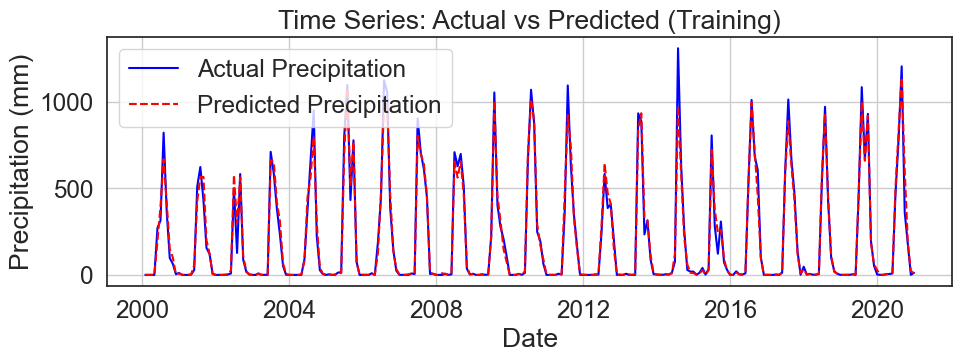

Generating cross-validation predictions...


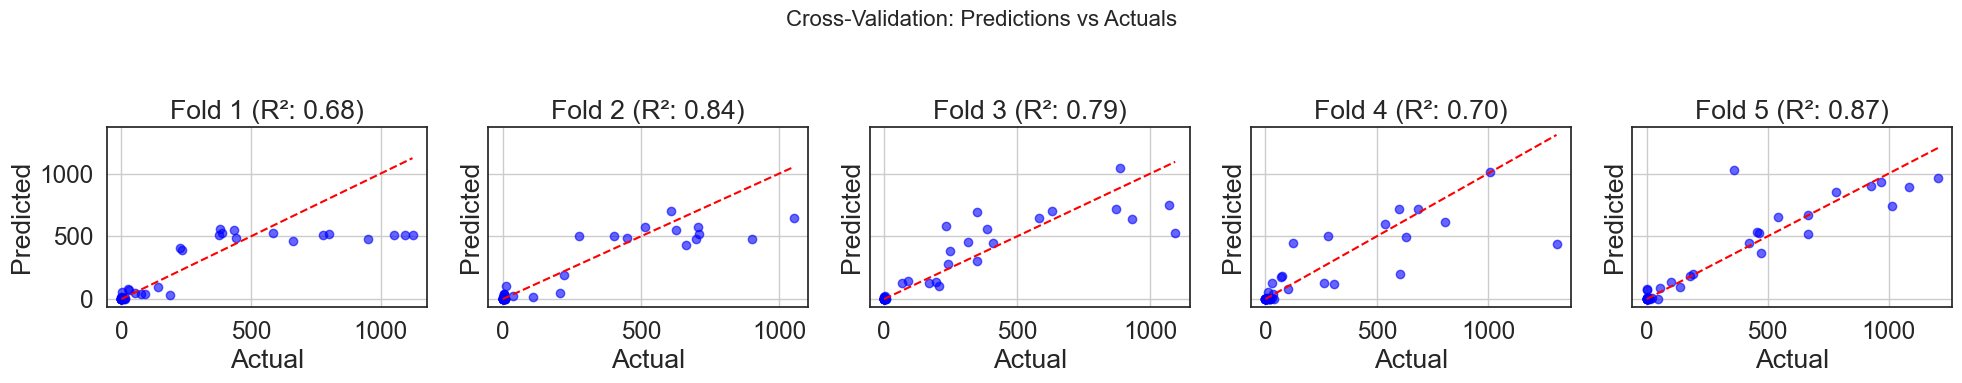

Time series plot saved to: Output_03/plots\time_series_training.png
Scatter plots saved to: Output_03/plots\scatter_cross_validation.png


In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Directory paths
input_dir = "Output_03/input"
model_dir = "Output_03/models"
results_dir = "Output_03/results"
plot_dir = "Output_03/plots"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Load historical data
data = pd.read_csv("Weather_Data.csv")
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('Date', inplace=True)
data = data[['Specific Humidity', 'Relative Humidity', 'Temperature', 'Precipitation']]

# Resample data to monthly granularity
monthly_data = data.resample('M').mean()

# Separate features and target
target_column = 'Precipitation'
features = monthly_data.drop(columns=[target_column])
target = monthly_data[target_column]

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1)).ravel()

# Train on the full dataset
print("Training on the full dataset...")
model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
model.fit(scaled_features, scaled_target)
predicted_scaled = model.predict(scaled_features)

# Inverse transform predictions and actuals
actual_values = target_scaler.inverse_transform(scaled_target.reshape(-1, 1)).flatten()
predicted_values = target_scaler.inverse_transform(predicted_scaled.reshape(-1, 1)).flatten()

# Metrics
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)
print(f"Training MSE: {mse:.2f}, R2: {r2:.2f}")

# Plot: Time series of training predictions vs actuals
plt.figure(figsize=(10, 4))
plt.plot(monthly_data.index, actual_values, label="Actual Precipitation", color="blue")
plt.plot(monthly_data.index, predicted_values, label="Predicted Precipitation", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("Time Series: Actual vs Predicted (Training)")
plt.legend()
plt.grid()
plt.tight_layout()
time_series_plot_path = os.path.join(plot_dir, "time_series_training.png")
plt.savefig(time_series_plot_path)
plt.show()

# Generate cross-validation predictions (manual cross-validation)
print("Generating cross-validation predictions...")
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(scaled_features)):
    X_train, X_test = scaled_features[train_idx], scaled_features[test_idx]
    y_train, y_test = scaled_target[train_idx], scaled_target[test_idx]
    
    # Train the model on the current fold
    model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and calculate metrics
    y_pred = model.predict(X_test)
    y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_actual = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    fold_r2 = r2_score(y_test_actual, y_pred_actual)
    
    fold_results.append((y_test_actual, y_pred_actual, fold_r2))

# Plot: Cross-validation scatter plots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
fig.suptitle("Cross-Validation: Predictions vs Actuals", fontsize=16)

for fold_idx, (y_actual, y_pred, fold_r2) in enumerate(fold_results):
    ax = axes[fold_idx]
    ax.scatter(y_actual, y_pred, alpha=0.6, color="blue")
    ax.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color="red", linestyle="--")
    ax.set_title(f"Fold {fold_idx + 1} (R²: {fold_r2:.2f})")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.grid()

scatter_plot_path = os.path.join(plot_dir, "scatter_cross_validation.png")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(scatter_plot_path)
plt.show()

# Output file paths
print(f"Time series plot saved to: {time_series_plot_path}")
print(f"Scatter plots saved to: {scatter_plot_path}")


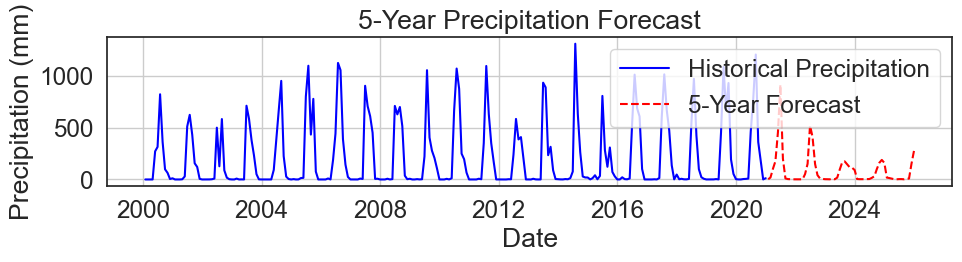

Time series plot saved to: Output_03/plots\time_series_training.png
Scatter plot saved to: Output_03/plots\scatter_cross_validation.png


In [22]:
# Load forecast input
forecast_input_path = os.path.join(input_dir, "5year_forecast_combined.csv")
forecast_input = pd.read_csv(forecast_input_path)

# Scale forecast input
forecast_input.set_index('Date', inplace=True)
forecast_features = forecast_input.drop(columns=[target_column])
scaled_forecast_input = feature_scaler.transform(forecast_features)

# Predict using the retrained model
predictions_scaled = best_model.predict(scaled_forecast_input)
predictions = target_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

# Generate forecast dates
last_date = monthly_data.index[-1]
forecast_steps = len(predictions)
forecast_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(), periods=forecast_steps, freq='M')

# Create a DataFrame for the forecast
forecast_df = forecast_input.reset_index()
forecast_df["Date"] = forecast_dates
forecast_df["Forecasted Precipitation"] = predictions

# Save the forecasted data
forecast_csv_path = os.path.join(results_dir, "forecasted_precipitation.csv")
forecast_df.to_csv(forecast_csv_path, index=False)

# Plot historical and forecasted data
plt.figure(figsize=(10, 3))
plt.plot(monthly_data.index, target, label="Historical Precipitation", color="blue", linestyle="-")
plt.plot(forecast_df["Date"], forecast_df["Forecasted Precipitation"], label="5-Year Forecast", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.title("5-Year Precipitation Forecast")
plt.legend()
plt.grid()
plt.tight_layout()

# Save and show the plot
plot_path = os.path.join(plot_dir, "precipitation_forecast.png")
plt.savefig(plot_path)
plt.show()


print(f"Time series plot saved to: {time_series_plot_path}")
print(f"Scatter plot saved to: {scatter_plot_path}")